# SC Analysis pipeline

Here we try to run a SOTA SC analysis pipeline for cell type annotation including
- QC
- UMAP
- Clustering
- Cell type Annotation using predefined markers
- Cell type annotation using DEG

adapted from https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

use cell markers from http://xteam.xbio.top/CellMarker/search.jsp?species=Human&tissue=Lung&cellname=Epithelial%20cell

This is for the scRNA-seq reference dataset, preprocessed in "Benchmarking pipeline/SingleCell reference/data_preprocessing.ipynb"

use the tmp_enact_analysis environment to run this script

In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Patch

In [2]:
cells_adata_path = "/srv/gstore/projects/p37785/SC_Lung_AC/adata.h5ad" 

method_name = "scRNA-seq"

# Loading Anndata object
adata = sc.read_h5ad(cells_adata_path)

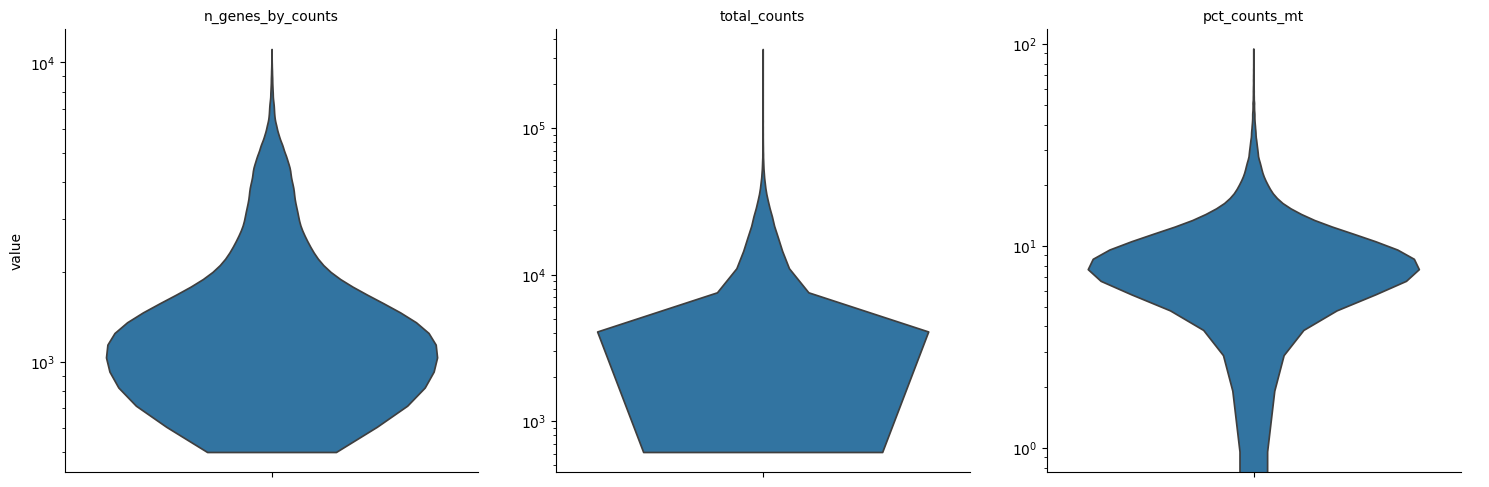

In [3]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

# Violin plot with log scale for y-axis
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    stripplot=False,
    multi_panel=True,
    log=True,
    save="_qc_violin.png"
)


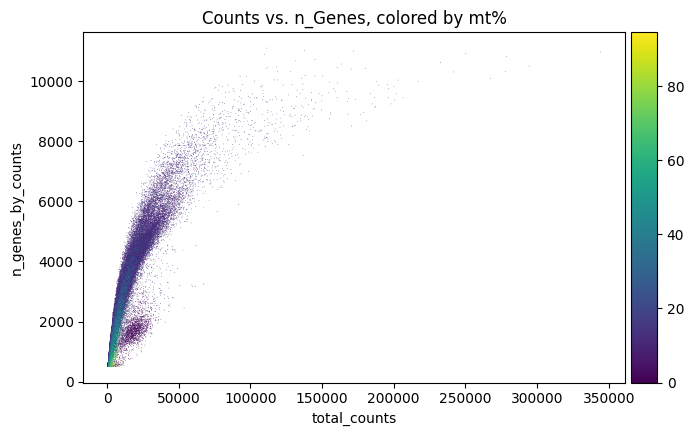

In [4]:
# Report mean and median for each metric
for col in ["n_genes_by_counts", "total_counts", "pct_counts_mt"]:
    mean_val = adata.obs[col].mean()
    median_val = adata.obs[col].median()

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="Counts vs. n_Genes, colored by mt%", save="_qc_scatter.png")

sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=3)

# skipping doublet detection as we expect no doublets in ST

adata.layers["counts"] = adata.X.copy()


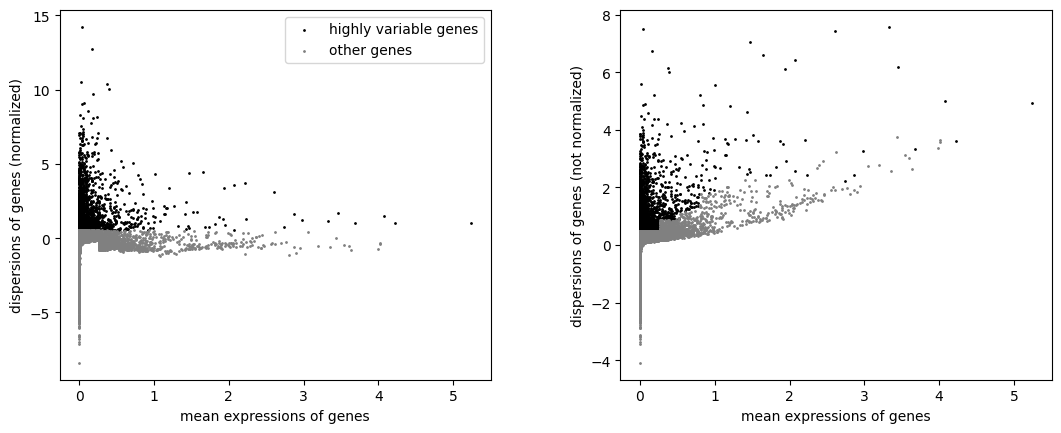

In [5]:

# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=4000)

sc.pl.highly_variable_genes(adata, save="_qc_hvg.png")


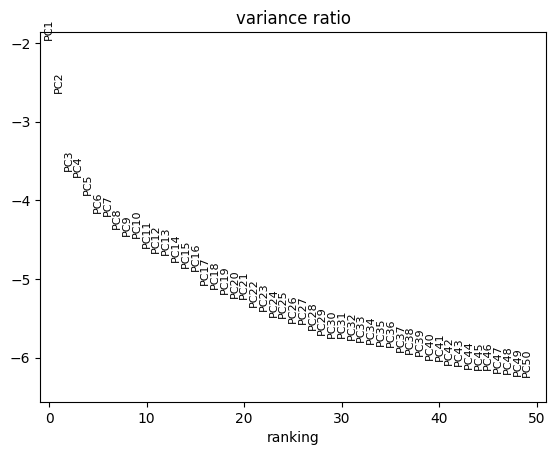

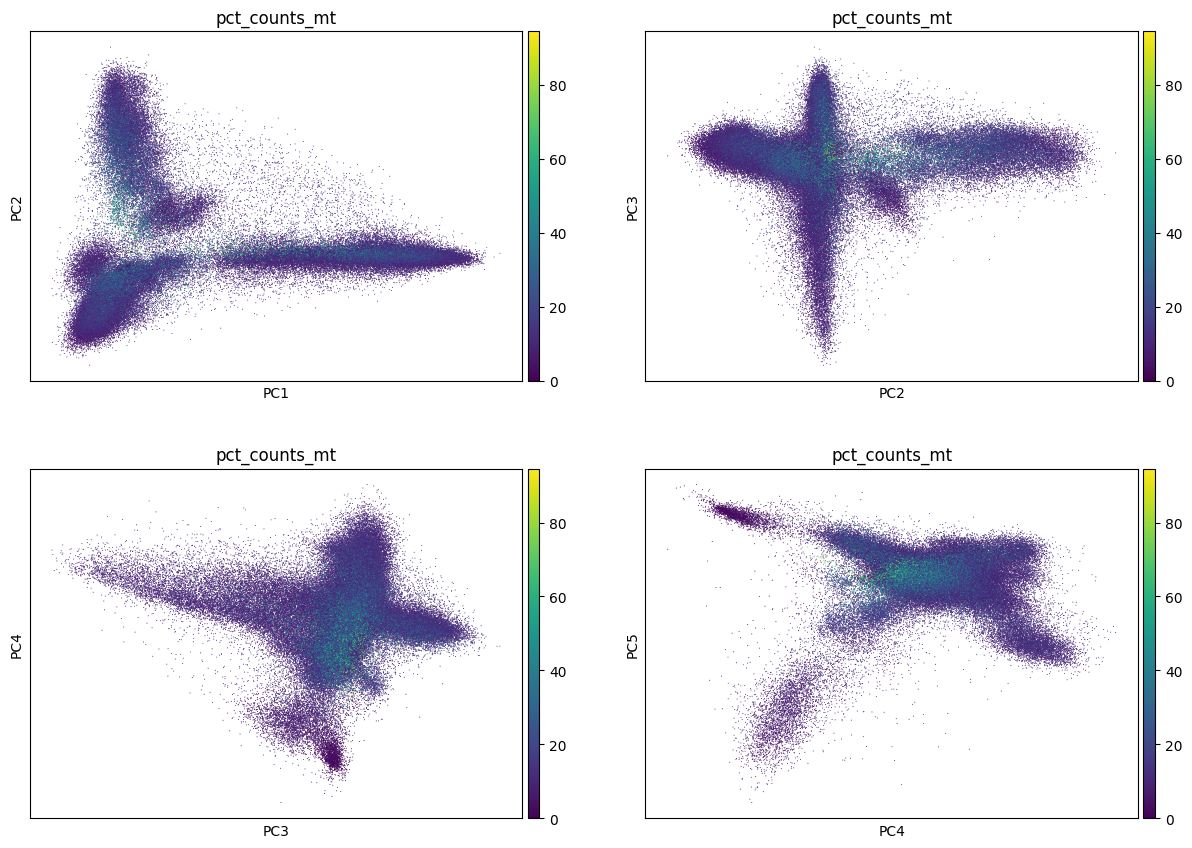

In [6]:

sc.tl.pca(adata)

sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True, save="_qc_pca_variance_ratio.png")

sc.pl.pca(
    adata,
    color=["pct_counts_mt", "pct_counts_mt", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (1, 2), (2, 3), (3, 4)],
    ncols=2,
    size=2,
    save="_qc_pca.png"
)

In [7]:
sc.pp.neighbors(adata)

/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-30 09:58:14.322543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-30 09:58:14.623893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-30 09:58:14.709327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 09:58:15.325890: I tensorflow/core/platform/cpu_feature_guard.cc:210] T

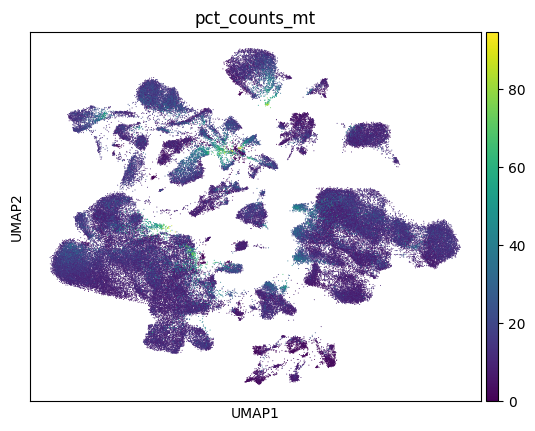

In [8]:
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color="pct_counts_mt",
    # Setting a smaller point size to get prevent overlap
    size=2,
    save="_qc_umap.png"
)

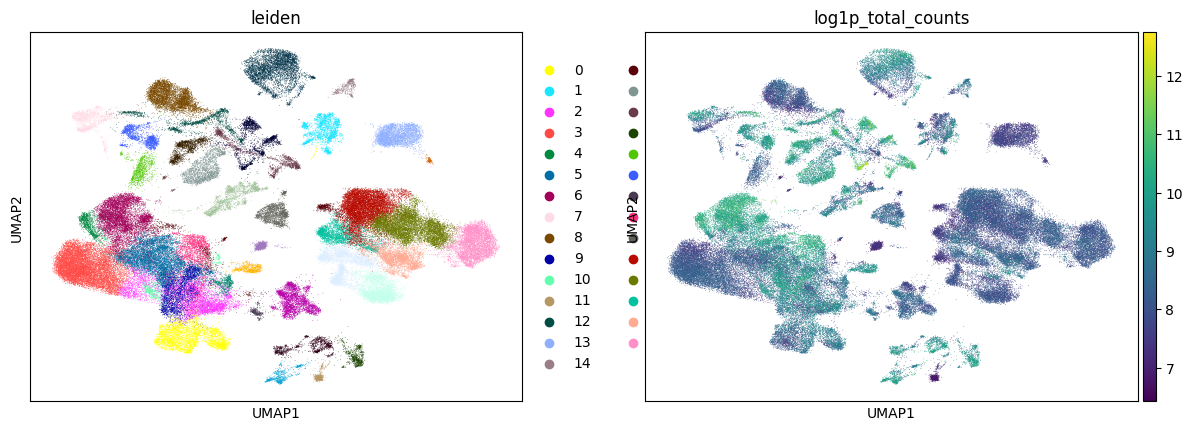

In [9]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

sc.pl.umap(adata, color=["leiden", "log1p_total_counts"], save="_qc_umap_leiden.png")


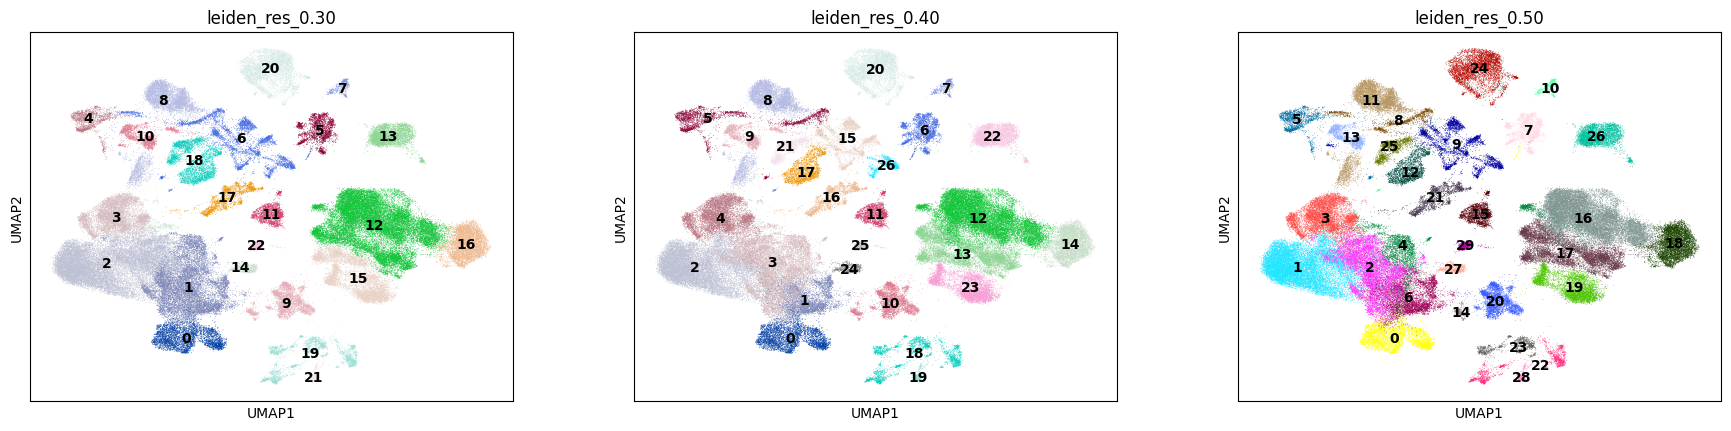

In [10]:
for res in [0.3,0.4, 0.5]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

sc.pl.umap(
    adata,
    color=["leiden_res_0.30", "leiden_res_0.40", "leiden_res_0.50"],
    legend_loc="on data",
    save="_qc_umap_leiden_resolutions.png"
)

In [11]:
marker_genes = {
    "Adenocarcinoma": ["MUC1", "CEACAM6", "NAPSA", "PHLDA2", "EPCAM"],
    "AT1": ["AGER", "PDPN", "CAV1", "RTKN2", "HOPX"],
    "AT2": ["SFTPC", "SFTPB", "SFTPA1", "SFTPA2", "NAPSA"],
    "B": ["CD19", "CD20", "MS4A1", "CD79A", "CD79B"],
    "Basal": ["KRT5", "KRT14", "TP63", "KRT17", "ITGA6"],
    "CD4": ["CD3D", "CD3E", "CD4", "IL7R", "CCR7"],
    "CD8": ["CD3D", "CD3E", "CD8A", "CD8B", "GZMB"],
    "Ciliated": ["FOXJ1", "RSPH1", "DNAI1", "CCDC39", "TUBA1A"],
    "DC": ["CD1C", "CLEC4C", "FCER1A", "IRF8", "CLEC9A"],
    "Endothelia": ["PECAM1", "VWF", "CDH5", "ENG", "FLT1"],
    "Fibro": ["COL1A1", "COL1A2", "VIM", "FN1", "ACTA2"],
    "Macro": ["CD68", "CD163", "CSF1R", "CD14", "MARCO"],
    "Mast": ["TPSAB1", "TPSB2", "CPA3", "MS4A2", "KIT"],
    "Monocyte": ["CD14", "FCGR3A", "CD16", "CCR2", "S100A8"],
    "NKT": ["KLRB1", "KLRD1", "KLRF1", "NCAM1", "CD3D"],
    "NK": ["KLRD1", "KLRF1", "NCAM1", "KLRB1", "PRF1"],
    "Secretory": ["SCGB1A1", "SCGB3A1", "CYP2F1", "BPIFA1", "MUC5AC"],
    "T": ["CD3D", "CD3E", "CD2", "CD7", "PTPRC"],
}
#"AT1 ", "AT2", "B","Basal", "CD4", "CD8","Ciliated","DC", "Endothelia", "Fibro","Macro","Mast","Monocyte", "NKT","NK","Secretory", "T",

In [12]:
# Filter marker_genes to only include genes present in adata.var_names
filtered_marker_genes = {
    cell_type: [gene for gene in genes if gene in adata.var_names]
    for cell_type, genes in marker_genes.items()
}

# Report the filtering result
for cell_type, genes in filtered_marker_genes.items():
    print(f"{cell_type}: {genes}")

Adenocarcinoma: ['MUC1', 'CEACAM6', 'NAPSA', 'PHLDA2', 'EPCAM']
AT1: ['AGER', 'PDPN', 'CAV1', 'RTKN2', 'HOPX']
AT2: ['SFTPC', 'SFTPB', 'SFTPA1', 'SFTPA2', 'NAPSA']
B: ['CD19', 'MS4A1', 'CD79A', 'CD79B']
Basal: ['KRT5', 'KRT14', 'TP63', 'KRT17', 'ITGA6']
CD4: ['CD3D', 'CD3E', 'CD4', 'IL7R', 'CCR7']
CD8: ['CD3D', 'CD3E', 'CD8A', 'CD8B', 'GZMB']
Ciliated: ['FOXJ1', 'RSPH1', 'DNAI1', 'CCDC39', 'TUBA1A']
DC: ['CD1C', 'CLEC4C', 'FCER1A', 'IRF8', 'CLEC9A']
Endothelia: ['PECAM1', 'VWF', 'CDH5', 'ENG', 'FLT1']
Fibro: ['COL1A1', 'COL1A2', 'VIM', 'FN1', 'ACTA2']
Macro: ['CD68', 'CD163', 'CSF1R', 'CD14', 'MARCO']
Mast: ['TPSAB1', 'TPSB2', 'CPA3', 'MS4A2', 'KIT']
Monocyte: ['CD14', 'FCGR3A', 'CCR2', 'S100A8']
NKT: ['KLRB1', 'KLRD1', 'KLRF1', 'NCAM1', 'CD3D']
NK: ['KLRD1', 'KLRF1', 'NCAM1', 'KLRB1', 'PRF1']
Secretory: ['SCGB1A1', 'SCGB3A1', 'CYP2F1', 'BPIFA1', 'MUC5AC']
T: ['CD3D', 'CD3E', 'CD2', 'CD7', 'PTPRC']


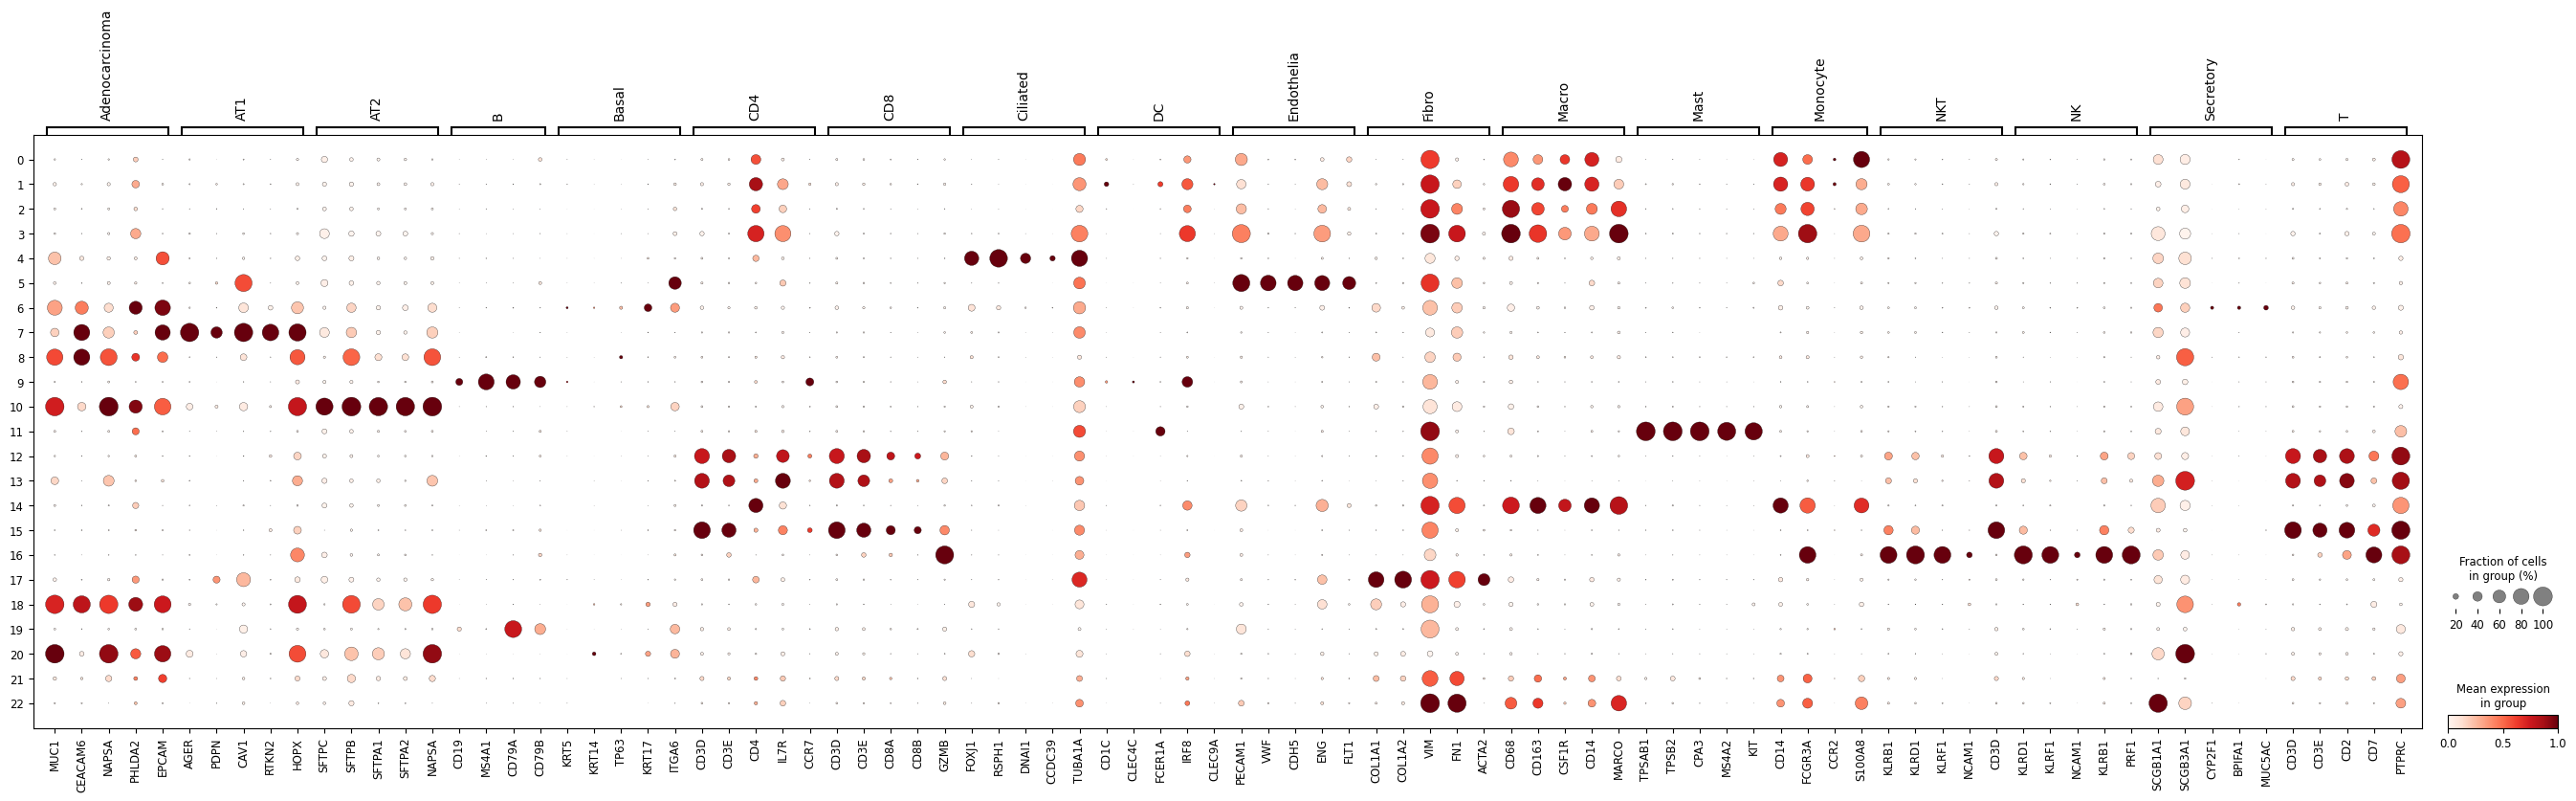

In [14]:
sc.pl.dotplot(adata, filtered_marker_genes, groupby="leiden_res_0.30", standard_scale="var")

In [16]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.30", method="wilcoxon")

/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/scanp

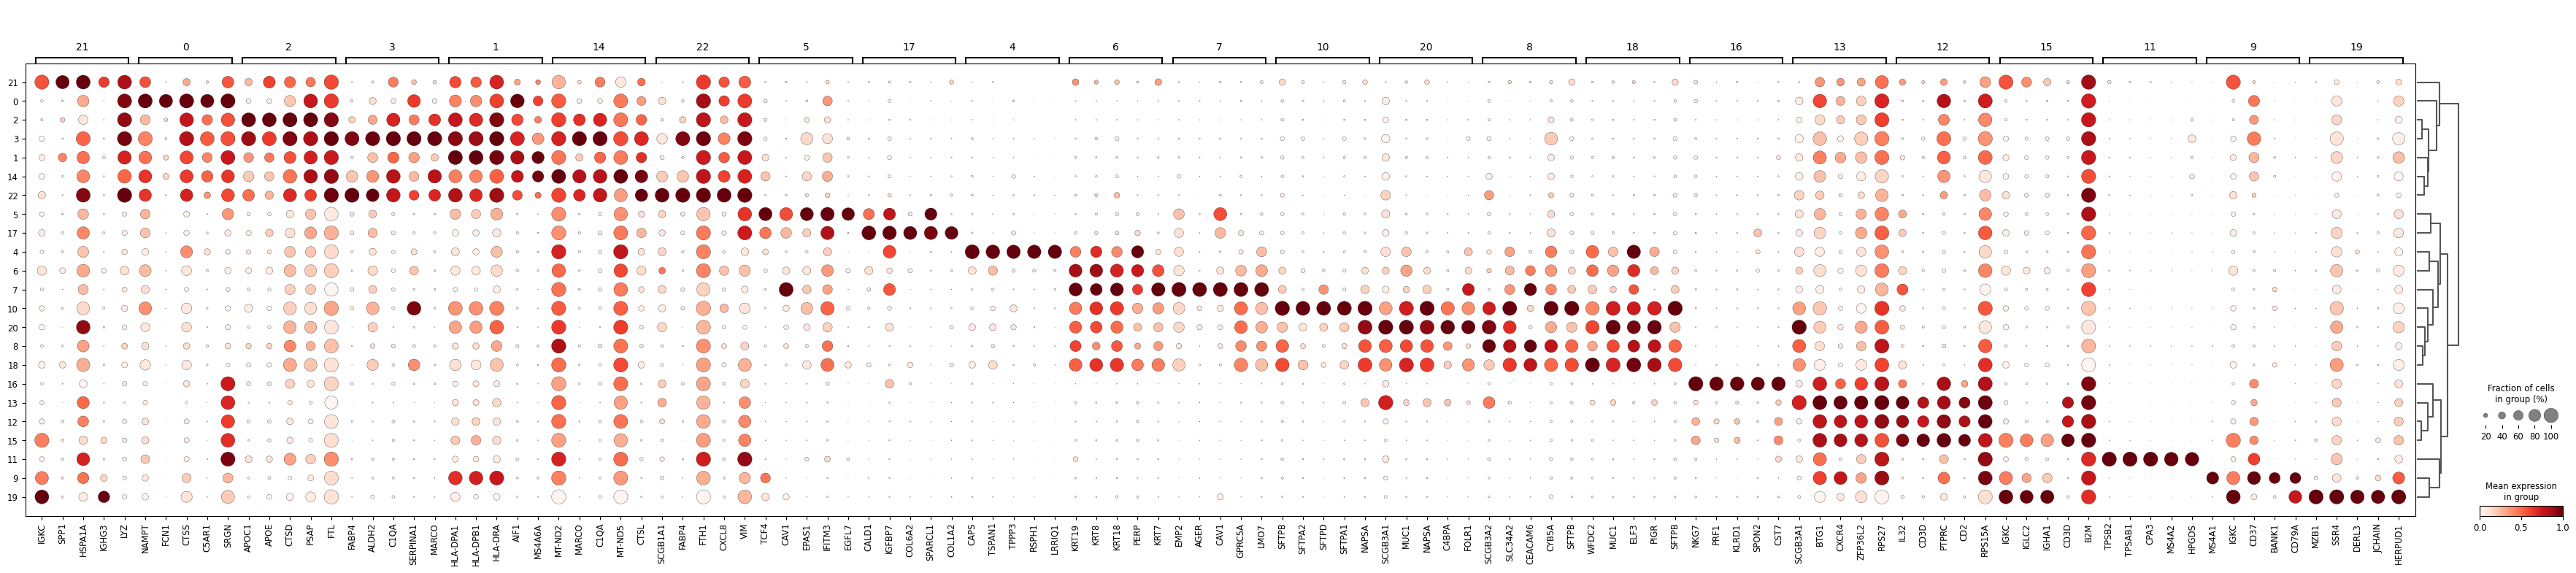

In [17]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.30", standard_scale="var", n_genes=5
)

In [18]:
groups = adata.obs["leiden_res_0.30"].cat.categories
# For each cluster in 'leiden_res_0.30', collect top 4 marker genes into a single dataframe
top_genes_list = []
for group in groups:
    df = sc.get.rank_genes_groups_df(adata, group=group).head(4)
    for _, row in df.iterrows():
        top_genes_list.append({
            "cluster": group,
            "gene": row["names"],
            "pvals_adj": row["pvals_adj"]
        })

top_genes_df = pd.DataFrame(top_genes_list)
print(top_genes_df)
top_genes_df.to_csv("top4_marker_genes_per_cluster_sc.csv", index=False)

   cluster      gene      pvals_adj
0        0     NAMPT   0.000000e+00
1        0      FCN1   0.000000e+00
2        0      CTSS   0.000000e+00
3        0     C5AR1   0.000000e+00
4        1  HLA-DPA1   0.000000e+00
..     ...       ...            ...
87      21     IGHG3  1.727719e-178
88      22   SCGB1A1   0.000000e+00
89      22     FABP4   0.000000e+00
90      22      FTH1   0.000000e+00
91      22     CXCL8   0.000000e+00

[92 rows x 3 columns]


In [19]:
import json

# Load the mapping from the JSON file
with open("./Cell_type_map_sota_sc.json", "r") as f:
    cluster_to_sotalabel = json.load(f)

# Map cluster labels to cell type labels
adata.obs["sotalabel"] = adata.obs["leiden_res_0.30"].map(cluster_to_sotalabel)

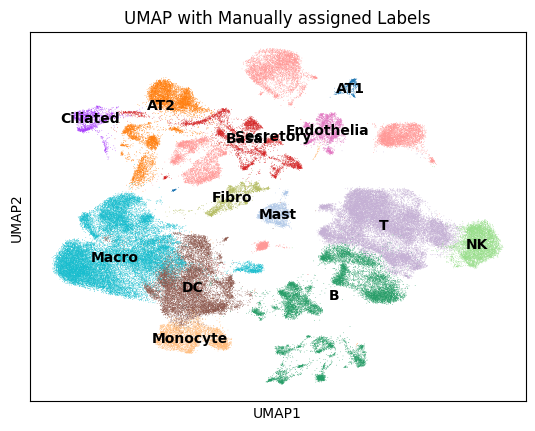

In [20]:
sc.pl.umap(
    adata,
    color=["sotalabel"],
    title="UMAP with Manually assigned Labels",
    legend_loc="on data",
    save="_qc_umap_leiden_resolutions.png"
)

In [21]:
adata.write("adata_with_labels_sc.h5ad")

In [22]:
label_list = ["AT1", "AT2", "B","Basal", "CD4", "CD8","Ciliated","DC", "Endothelia", "Fibro",
"Macro","Mast","Monocyte", "NKT","NK","Secretory", "T" , "other"] 

In [23]:
# Compute cell type proportions for all available cell types in label_list
cell_type_counts = adata.obs["sotalabel"].value_counts()
total_cells = len(adata)

proportions = []
for ct in label_list:
    count = cell_type_counts.get(ct, 0)
    prop = count / total_cells
    proportions.append({"cell_type": ct, "count": count, "proportion": prop})

cell_type_proportions_df = pd.DataFrame(proportions)
print(cell_type_proportions_df)

     cell_type  count  proportion
0          AT1    539    0.004456
1          AT2   7657    0.063301
2            B  13976    0.115541
3        Basal   4794    0.039633
4          CD4      0    0.000000
5          CD8      0    0.000000
6     Ciliated   1646    0.013608
7           DC  12487    0.103232
8   Endothelia   2420    0.020006
9        Fibro   1924    0.015906
10       Macro  26858    0.222039
11        Mast   1890    0.015625
12    Monocyte   4234    0.035003
13         NKT      0    0.000000
14          NK   5475    0.045263
15   Secretory  13170    0.108878
16           T  23891    0.197510
17       other      0    0.000000


In [24]:
# Load the CSV file
existing_df = pd.read_csv("cell_type_proportions.csv")

# Append the current proportions as a new column labeled 'scRNA-seq'
existing_df[method_name] = cell_type_proportions_df["proportion"]

# Save the updated dataframe back to CSV
existing_df.to_csv("cell_type_proportions.csv", index=False)